In [380]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import itertools
from scipy import stats
from tqdm import tqdm_notebook
from outliers import smirnov_grubbs as grubbs
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
%cd _bio_eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Errno 2] No such file or directory: '_bio_eval'
/media/data/DeepFLaSH/_bio_eval


## Choose Labs

### Lab Inns_01

In [409]:
LAB = 'inns_01'
name = 'Lucas'
groups = {'Ctrl' : 0, 'Ext' : 1}
MASK = 'cFOS'
OUTLIERS = ['1080']

### Lab Inns_02

In [400]:
LAB = 'inns_02'
name = 'Anupam'
groups = {'Saline' : 0, 'L-DOPA responder' : 1, 'L-DOPA non-responder' : 2}
MASK = 'cFOS'
OUTLIERS = []

### Lab Mue

In [415]:
LAB = 'mue'
name = 'Maren'
groups = {'Ext' : 0, 'Ret' : 1}
MASK = 'cFOS'
OUTLIERS = []

### Lab Wue_02

In [421]:
LAB = 'wue_02'
name = 'Lab_Wue_02'
groups = {'WT' : 0, 'KO' : 1}
MASK = 'Parv'
OUTLIERS = ['1699']

## Run Eval

In [422]:
#Load Data
df_zuordnung = pd.read_excel('../data/Zuordnung_corr.xlsx')
df_zu = df_zuordnung[(df_zuordnung['name']==name)&
                (df_zuordnung['Experiment']=='Test')&
                (df_zuordnung['Cross-coder Training'].isna()) & 
                (df_zuordnung['Ausschluss von Analyse'].isna()) &
                (df_zuordnung['broken'].isna())].copy()
df_zu['Group'] = df_zu['Kondition'].transform(lambda x: groups[x])
#df_cfos = pd.read_csv(os.path.join(LAB,LAB+'_' + MASK + '_results.csv'))
df_cfos = pd.read_csv(os.path.join(LAB,LAB+'_' + MASK + '_ROIs.csv'))
df_neun = pd.read_csv(os.path.join(LAB,LAB+'_NeuN_results.csv'))

#Merge Data
df = df_cfos.groupby(['ens', 'unet', 'fold', 'Nummer']).mean_intensity.agg(['mean', 'count'])
df = df.join(df_neun.set_index('Nummer')[['Neun_Area']], how='left', on='Nummer')
df = df.join(df_zu.set_index('Nummer')[['Kondition', 'Group']], how='left', on='Nummer')

#Normalize counts
df['cfos_per_area'] = df['count']/df['Neun_Area']
ctlr_norm = df[df.Group == 0].groupby(['ens', 'unet', 'fold'])[['cfos_per_area', 'mean']].agg(np.mean)
df = df.join(ctlr_norm, rsuffix='_ctrl')
df['norm_cfos_per_area'] = df['cfos_per_area']/df['cfos_per_area_ctrl']
df['norm_mean_intensity'] = df['mean']/df['mean_ctrl']

#Remove Outliers
df = df[~df.index.isin(OUTLIERS, level=3)]

### Check for Outliers

In [423]:
df.groupby('Nummer')[['norm_mean_intensity', 'norm_cfos_per_area']].agg('count').sort_values(by='norm_mean_intensity').head()

,norm_mean_intensity,norm_cfos_per_area
Nummer,,
1697,4,44
1693,37,44
1674,44,44
1694,44,44
1695,44,44


In [427]:
def get_outlier_names(x):
    out_ind = grubbs.two_sided_test_indices(x, alpha=0.05)
    if len(out_ind)>0:
        return str(x.iloc[out_ind].index.get_level_values('Nummer').values)
    else:
        return 'No Outliers'

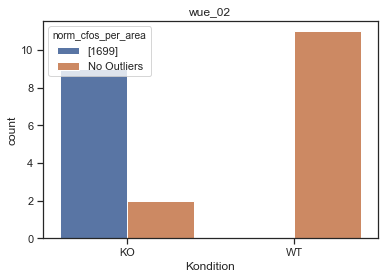

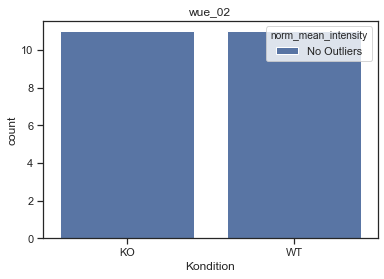

In [428]:
#df = df[df.index.get_level_values('unet').str[:3]=='ens']
df_out = df.groupby(['ens', 'unet', 'fold', 'Kondition'])[['norm_cfos_per_area', 'norm_mean_intensity']].agg(get_outlier_names).reset_index()
ax = sns.countplot(x="Kondition", hue='norm_cfos_per_area', data=df_out).set_title(LAB)
plt.show()
ax = sns.countplot(x="Kondition", hue='norm_mean_intensity', data=df_out).set_title(LAB)

## Compute effects

In [398]:
df_list = []
c_alpha = 0.05
for key2, grp2 in tqdm_notebook(df.groupby(['ens', 'unet', 'fold'])):

    for m in ['norm_cfos_per_area', 'norm_mean_intensity']:
        res_dict = {'ens': [key2[0]], 'unet': [key2[1]],
                    'fold': [key2[2]], 'type': [m]}
        
        df_fil = grp2[~grp2[m].isna()]
        
        if all(df_fil.groupby('Group').size()>3):
            grp_data = [x[1] for x in df_fil.groupby('Group', sort=True)[m]]
            n_groups = len(grp_data)
            
            # Get Group Means/Median
            grp_means = [x.mean() for x in grp_data]   
            grp_medians = [x.median() for x in grp_data]       
            
            # Perform the Shapiro-Wilk test for normality.
            grp_norms = [x[1] for x in map(stats.shapiro, grp_data)]
            
            #Check for equality of variances
            if len(grp_data)>2:
                _, levene = stats.levene(*grp_data, center = 'mean')
            else:
                _, levene = stats.levene(*grp_data, center = 'median')
            
            # Anova possible?
            anova = True if all(np.array([*grp_norms,levene])> 0.05) else False
            res_dict['anova_ok'] = [anova]
        
            # Only 3 groups tests
            if n_groups==3: 
                
                # kruskal all groups
                H, kwa_p_value = stats.kruskal(*grp_data)
                N = len(df_fil)
                
                kwa_eta_squared = (H - n_groups + 1)/(N-n_groups) # http://tss.awf.poznan.pl/files/3_Trends_Vol21_2014__no1_20.pdf
                # kwa_eta_squared = ((H / (n_groups-1)) * (n_groups-1)) / ((H / (n_groups-1)) * (n_groups-1) + (N-n_groups)) 
                #For references, see: https://www.researchgate.net/post/Anyone_know_how_to_calculate_eta_squared_for_a_Kruskal-Wallis_analysis
                res_dict['eta^2_kwa_all'] = [kwa_eta_squared]
                res_dict['p_kwa_all'] = [kwa_p_value]
                res_dict['kwa_all'] = 1 if kwa_p_value<0.05 else 0
                # Critical Value
                p = 1-c_alpha
                ddof = n_groups-1
                H_c = stats.chi2.ppf(p, ddof) 
                kwa_eta_squared_c = (H_c- n_groups + 1)/(N-n_groups) 
                res_dict['c_kwa_all'] = [kwa_eta_squared_c]
                
                # ANOVA All groups
                aov = pg.anova(dv=m, between='Group', data=df_fil, detailed=False)
                aov_p_value = aov['p-unc'][0]
                res_dict['eta^2_aov_all'] = [aov['np2'][0]]
                res_dict['p_aov_all'] = [aov_p_value]
                res_dict['aov_all'] = 1 if aov_p_value<0.05 else 0
                # Critical Value
                # Calculating partial eta-square (fval * ddof1) / (fval * ddof1 + ddof2) 
                # https://pingouin-stats.org/_modules/pingouin/parametric.html#anova
                ddof1 = n_groups - 1
                ddof2 = N - n_groups
                fval = stats.f.ppf(p, ddof1, ddof2) 
                aov_eta_squared_c = (fval * ddof1) / (fval * ddof1 + ddof2) 
                res_dict['c_aov_all'] = [aov_eta_squared_c]

            # Pairwise tests
            for i,j in itertools.combinations(range(len(grp_data)), 2):
                k, l = i+1, j+1
                
                # Pairwise mannwhitneyu tests
                U, mwu_p_value = stats.mannwhitneyu(grp_data[i],grp_data[j], alternative = 'two-sided')
                n_1 = grp_data[i].count()
                n_2 = grp_data[j].count()
                N = n_1 + n_2
                mwu_eta_squared = ((U - (n_1*n_2/2)) / np.sqrt((n_1*n_2*(n_1+n_2+1))/12) / np.sqrt(n_1+n_2))**2
                # according to http://www.statisticslectures.com/topics/mannwhitneyu/ & cross-checked with Origin & psychometrica
                res_dict['eta^2_mwu{}_vs_{}'.format(k,l)] = [mwu_eta_squared]
                res_dict['p_mwu{}_vs_{}'.format(k,l)] = [mwu_p_value]
                # Critical Value
                p = 1-c_alpha if n_groups==2 else 1-(c_alpha/n_groups)
                U_c = stats.chi2.ppf(p, 1)
                mwu_eta_squared_c = U_c/N 
                # Eta squared can be calculated as η²=r²=chi²/N. Note that the Kruskal-Wallis H test statistic is approximately chi²-distributed.
                res_dict['c_mwu{}_vs_{}'.format(k,l)] = [mwu_eta_squared_c]
                # Direction check  
                mwu_i_vs_j = 0  
                if grp_medians[i] != grp_medians[j]:
                    if all((n_groups==2, mwu_p_value <= c_alpha)) ^ all((n_groups>2, mwu_p_value <= c_alpha/n_groups)):
                        mwu_i_vs_j = k if (grp_medians[i] > grp_medians[j]) else l
                res_dict['mwu{}_vs_{}'.format(k,l)] = [mwu_i_vs_j] 
                
                # Pairwise ANOVA
                aov = pg.anova(dv=m, between='Group', data=df_fil[df_fil['Group'].isin([i,j])], detailed=False)
                aov_p_value = aov['p-unc'][0]   
                res_dict['eta^2_aov{}_vs_{}'.format(k,l)] = [aov['np2'][0]]
                res_dict['p_aov{}_vs_{}'.format(k,l)] = [aov_p_value]
                # Critical Value
                ddof1 = 2-1
                ddof2 = N-2
                fval = stats.f.ppf(p, ddof1, ddof2) 
                aov_eta_squared_c = (fval * ddof1) / (fval * ddof1 + ddof2) 
                res_dict['c_aov{}_vs_{}'.format(k,l)] = [aov_eta_squared_c]
                # Direction check
                aov_i_vs_j = 0  
                if grp_means[i] != grp_means[j]:
                    if all((n_groups==2, aov_p_value <= c_alpha)) ^ all((n_groups>2, aov_p_value <= c_alpha/n_groups)):
                        aov_i_vs_j = k if (grp_means[i] > grp_means[j]) else l
                res_dict['aov{}_vs_{}'.format(k,l)] = [aov_i_vs_j] 
                
                 
        df_list += [pd.DataFrame(res_dict)]

df_final = pd.concat(df_list)

In [399]:
df_final.to_csv(os.path.join('_results/'+ LAB +'_effect.csv'), index=False)
df_final[df_final.type=='norm_cfos_per_area'].to_csv(os.path.join('_results/'+ LAB+'_effect_count.csv'), index=False)
df_final[df_final.type=='norm_mean_intensity'].to_csv(os.path.join('_results/'+ LAB+'_effect_intensity.csv'), index=False)